Modeling Memberships in Social Circles with Graph-based Features

In this notebook, we build and evaluate machine learning models to predict whether two friends in an ego network both belong to at least one common social circle.

- **Input:** Pairwise graph-based features from `pair_graph_features_only.csv`
- **Output:** Binary classifications whether the pair of friends share a social circle (`label = 1` or `0`)
- **Objective:** Compare basic baselines to LogReg (and Random Forest) in order to understand how well graph structure is at explaining social circle memberships.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

1. Load Dataset `../Graph_Features/pair_graph_features_only.csv`
- Each row corresponds to a pair of nodes `(u, v)` in an ego network.
- The target `label` is `1` if the pair shares at least one social circle, `0` otherwise.

In [ ]:
DATA_PATH = "../Graph_Features/pair_graph_features_only.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (1394586, 17)


,ego_id,u,v,label,common_neighbors,jaccard,adamic_adar,resource_allocation,preferential_attachment,shortest_path_len,same_component,is_edge,deg_u,deg_v,deg_min,deg_max,deg_diff
0,239,240,241,1,6,0.375000,2.828988,0.746825,105,1,1,1,7,15,7,15,8
1,239,240,242,1,4,0.285714,1.607905,0.359524,77,2,1,0,7,11,7,11,4
2,239,240,243,1,1,0.045455,0.214871,0.009524,112,2,1,0,7,16,7,16,9
3,239,240,251,1,1,0.041667,0.214871,0.009524,126,2,1,0,7,18,7,18,11
4,239,240,253,1,1,0.058824,0.214871,0.009524,77,2,1,0,7,11,7,11,4


In [4]:
print("Columns:", df.columns.tolist())
print("\nLabel distribution (proportions):")
print(df["label"].value_counts(normalize=True))

Columns: ['ego_id', 'u', 'v', 'label', 'common_neighbors', 'jaccard', 'adamic_adar', 'resource_allocation', 'preferential_attachment', 'shortest_path_len', 'same_component', 'is_edge', 'deg_u', 'deg_v', 'deg_min', 'deg_max', 'deg_diff']

Label distribution (proportions):
label
0    0.621551
1    0.378449
Name: proportion, dtype: float64


2. Define Features and Target

- We drop identifier columns (`ego_id`, `u`, `v`) and keep only numeric graph-based features as inputs.
- **Target:** `label`
- **Features:** all other numeric columns

In [5]:
TARGET_COL = "label"
ID_COLS = ["ego_id", "u", "v"]

feature_cols = [c for c in df.columns if c not in ID_COLS + [TARGET_COL]]

X = df[feature_cols].astype("float32")
y = df[TARGET_COL]

print("Feature columns:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)

Feature columns: ['common_neighbors', 'jaccard', 'adamic_adar', 'resource_allocation', 'preferential_attachment', 'shortest_path_len', 'same_component', 'is_edge', 'deg_u', 'deg_v', 'deg_min', 'deg_max', 'deg_diff']
X shape: (1394586, 13)
y shape: (1394586,)


3. Train/Test Split so that label proportions are consistent across splits.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))

Train size: 1115668
Test size: 278918
Train label distribution:
 label
0    0.621551
1    0.378449
Name: proportion, dtype: float64
Test label distribution:
 label
0    0.621552
1    0.378448
Name: proportion, dtype: float64


4. Baseline Models

Evaluating upon two simple baselines:

- **Majority Baseline:** always predict the most common class.
- **Random Baseline:** predict 0 or 1 uniformly at random.

In [19]:
# Majority class baseline
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

baseline_majority_acc = accuracy_score(y_test, y_pred_majority)
baseline_majority_f1 = f1_score(y_test, y_pred_majority, zero_division=0)

# Random baseline
rng = np.random.default_rng(seed=42)
y_pred_random = rng.integers(low=0, high=2, size=len(y_test))

baseline_random_acc = accuracy_score(y_test, y_pred_random)
baseline_random_f1 = f1_score(y_test, y_pred_random, zero_division=0)

print("BASELINE PERFORMANCE:")
print(f"Majority baseline: accuracy = {baseline_majority_acc:.4f}, F1 = {baseline_majority_f1:.4f}")
print(f"Random baseline:   accuracy = {baseline_random_acc:.4f}, F1 = {baseline_random_f1:.4f}")

BASELINE PERFORMANCE:
Majority baseline: accuracy = 0.6216, F1 = 0.0000
Random baseline:   accuracy = 0.5002, F1 = 0.4312


5. Logistic Regression with Feature Scaling

- We fit a Logistic Regression model with standardized features accounting for any label imbalance.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [10]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs"
)

lr.fit(X_train_scaled, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


Evaluating LogReg model performance using:
- Accuracy
- F1-score
- ROC AUC
- Confusion matrix

In [21]:
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("LOGISTIC REGRESSION PERFORMANCE:")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"F1-score:  {f1_lr:.4f}")
print(f"ROC AUC:   {auc_lr:.4f}")
print("\nConfusion Matrix:")
print(cm_lr)

print("\nClassification Summary:")
print(classification_report(y_test, y_pred_lr, digits=4))


LOGISTIC REGRESSION PERFORMANCE:
Accuracy:  0.7848
F1-score:  0.6550
ROC AUC:   0.8015

Confusion Matrix:
[[161904  11458]
 [ 48571  56985]]

Classification Summary:
              precision    recall  f1-score   support

           0     0.7692    0.9339    0.8436    173362
           1     0.8326    0.5399    0.6550    105556

    accuracy                         0.7848    278918
   macro avg     0.8009    0.7369    0.7493    278918
weighted avg     0.7932    0.7848    0.7722    278918



<Figure size 640x480 with 0 Axes>

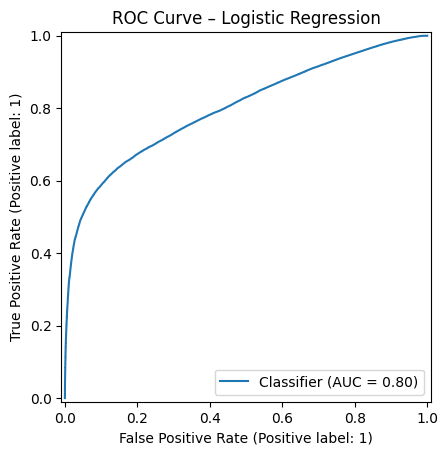

In [12]:
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve – Logistic Regression")
plt.show()

6. Interpretation

In [22]:
coeffs = lr.coef_[0]
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})

feature_importance["abs_coeff"] = feature_importance["coefficient"].abs()
feature_importance = feature_importance.sort_values("abs_coeff", ascending=False)

feature_importance


,feature,coefficient,abs_coeff
0,common_neighbors,13.277911,13.277911
2,adamic_adar,-12.995310,12.995310
3,resource_allocation,3.202789,3.202789
4,preferential_attachment,-1.241184,1.241184
1,jaccard,0.405536,0.405536
10,deg_min,0.197056,0.197056
9,deg_v,0.104042,0.104042
8,deg_u,0.084149,0.084149
12,deg_diff,-0.071399,0.071399
11,deg_max,0.056759,0.056759


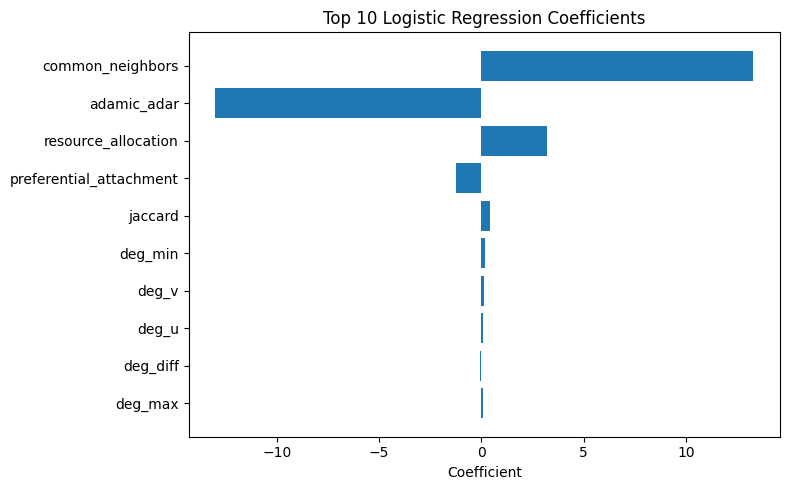

In [14]:
top_k = 10
top_features = feature_importance.head(top_k)

plt.figure(figsize=(8, 5))
plt.barh(top_features["feature"][::-1], top_features["coefficient"][::-1])
plt.xlabel("Coefficient")
plt.title(f"Top {top_k} Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


7. Random Forest Comparison

- To compare against a non-linear model, we train a Random Forest classifier on a subsample of the training data as an additional reference point for later evaluation.


In [23]:
# Subsample for RF to keep training time reasonable
SUBSAMPLE = 200_000  # reduce if needed

train_subset = X_train.copy()
train_subset["label"] = y_train.values

if len(train_subset) > SUBSAMPLE:
    train_subset = train_subset.sample(SUBSAMPLE, random_state=42)

X_train_rf = train_subset[feature_cols]
y_train_rf = train_subset["label"]

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

print("RANDOM FOREST PERFORMANCE")
print(f"Accuracy:  {acc_rf:.4f}")
print(f"F1-score:  {f1_rf:.4f}")
print(f"ROC AUC:   {auc_rf:.4f}")

RANDOM FOREST PERFORMANCE
Accuracy:  0.7935
F1-score:  0.7261
ROC AUC:   0.8570


8. Summary

In [24]:
results = pd.DataFrame([
    {
        "model": "Majority baseline",
        "accuracy": baseline_majority_acc,
        "f1": baseline_majority_f1,
        "roc_auc": np.nan
    },
    {
        "model": "Random baseline",
        "accuracy": baseline_random_acc,
        "f1": baseline_random_f1,
        "roc_auc": np.nan
    },
    {
        "model": "Logistic Regression",
        "accuracy": acc_lr,
        "f1": f1_lr,
        "roc_auc": auc_lr
    },
    {
        "model": "Random Forest (subset)",
        "accuracy": acc_rf,
        "f1": f1_rf,
        "roc_auc": auc_rf
    }
])

results

,model,accuracy,f1,roc_auc
0,Majority baseline,0.621552,0.000000,NaN
1,Random baseline,0.500176,0.431198,NaN
2,Logistic Regression,0.784779,0.655004,0.801457
3,Random Forest (subset),0.793538,0.726115,0.856973
